# HW03
## Optimization Algorithms

Hortencia Alejadnra Ramírez Vázquez A01750150

Amanda Valdez Calderón 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Test Problems

In [14]:
# Test Problems

def himmelblau(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

def griewank(x):
    x = np.array(x)
    return (x[0]**2 + x[1]**2)/4000 - np.cos(x[0]) * np.cos(x[1]/np.sqrt(2)) + 1

def rastrigin(x):
    A = 10
    return A * len(x) + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])

def rosenbrock(x):
    return (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2 

functions = {himmelblau: [(-3,3),(-3,3)], 
             griewank : [(-5,5),(-5,5)], 
             rastrigin : [(-5.12, 5.12), (-5.12, 5.12)], 
             rosenbrock: [(-2.048, 2.048), (-2.048, 2.048)]
            }

In [15]:
# Metrics Calculation

def metrics(fitness_list):
    optimal_value = 0
    tolerance = 1e-6
    count_optimal = np.sum(np.abs(fitness_list - optimal_value) <= tolerance)

    mean_val = np.mean(fitness_list)
    median_val = np.median(fitness_list)
    std_val = np.std(fitness_list)

    return count_optimal, mean_val, median_val, std_val

## Genetic Algorithm

In [16]:
def init_population(pop_size, dim, low, high, rng):
    return rng.uniform(low, high, size=(pop_size, dim))

# crossover: SBX (Simulated Binary Crossover)
def crossover(p1, p2, eta_c, rng):
  u = rng.random(len(p1))
  beta = np.where(u <= 0.5,
                  (2.0*u)**(1.0/(eta_c+1.0)),
                  (1.0/(2.0*(1.0-u)))**(1.0/(eta_c+1.0)))
  c1 = 0.5*((1+beta)*p1 + (1-beta)*p2)
  c2 = 0.5*((1-beta)*p1 + (1+beta)*p2)
  return c1, c2

# mutation: Parameter-based mutation (PM)
def mutate(x, low, high, pm, rng, eta_m=20):

  x = np.asarray(x, dtype=float)
  low  = np.asarray(low,  dtype=float) if np.ndim(low)  else float(low)
  high = np.asarray(high, dtype=float) if np.ndim(high) else float(high)

  x = np.clip(x, low, high)
  x_new = x.copy()

  #mask of genes
  m = rng.random(x.shape) < pm

  eta_p1 = float(eta_m) + 1.0
  eps_w = 1e-12

  for idx in np.where(m)[0]:
    yl = low[idx]  if np.ndim(low)  else low
    yu = high[idx] if np.ndim(high) else high
    w  = yu - yl
    if w <= eps_w:
      continue

    u = float(rng.random())

    xi = float(x_new[idx])
    delta = min(xi - yl, yu - xi) / w
    delta = float(np.clip(delta, 0.0, 1.0))

    base = (1.0 - delta) ** eta_p1
    if u <= 0.5:
        dq = (2.0 * u + (1.0 - 2.0 * u) * base) ** (1.0 / eta_p1) - 1.0
    else:
        dq = 1.0 - (2.0 * (1.0 - u) + 2.0 * (u - 0.5) * base) ** (1.0 / eta_p1)

    x_new[idx] = np.clip(xi + dq * w, yl, yu)

  return x_new

# selection: binary tournament (deterministic)
def selection(fitnesses, rng):
    i, j = rng.integers(0, len(fitnesses), size=2)
    return i if fitnesses[i] <= fitnesses[j] else j

# evaluate population
def evaluate(pop, fit_fn):
    return np.array([fit_fn(ind) for ind in pop])


In [17]:
# Genetic Algorithm
def genetic_algorithm(function, pop_size, dim, low, high, gens, eta_c, pm, eta_m, rng):
    pop = init_population(pop_size, dim, low, high, rng)
    best_fitness_list = []

    for g in range(gens):
        fits = evaluate(pop, function)

        elite_idx = np.argmin(fits)
        elite = pop[elite_idx].copy()
        elite_fit = fits[elite_idx]

        # store best-so-far (monotone)
        if best_fitness_list:
            best_fitness_list.append(min(best_fitness_list[-1], elite_fit))
        else:
            best_fitness_list.append(elite_fit)

        new_pop = [elite]

        while len(new_pop) < pop_size:
            # selection
            i = selection(fits, rng)
            j = selection(fits, rng)
            p1, p2 = pop[i], pop[j]

            # crossover (SBX)
            c1, c2 = crossover(p1, p2, eta_c, rng)

            # mutation (PM)
            c1 = mutate(c1, low, high, pm, rng, eta_m=eta_m)
            c2 = mutate(c2, low, high, pm, rng, eta_m=eta_m)

            new_pop.extend([c1, c2])

        pop = np.array(new_pop[:pop_size])

    # return final population and the best history
    return pop, best_fitness_list

### Test

In [18]:
# Parameters
num_runs = 31

best_fitness = []
best_solutions = []

dim = 2
pop_size = 100
gens = 100
eta_c = 15
pm = 1.0/dim
eta_m = 20

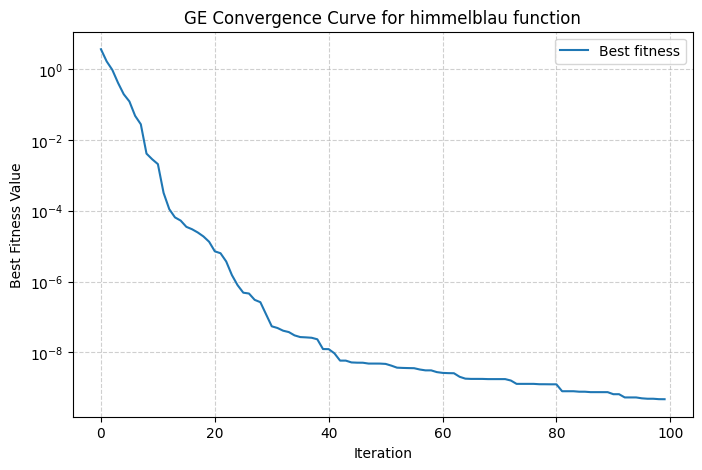

<Figure size 640x480 with 0 Axes>

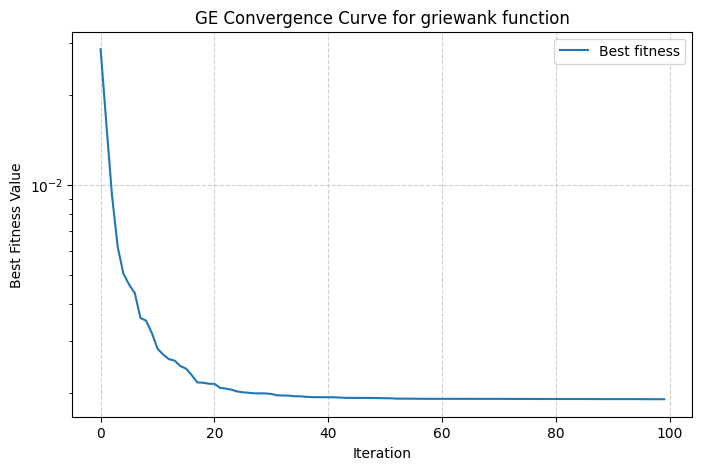

<Figure size 640x480 with 0 Axes>

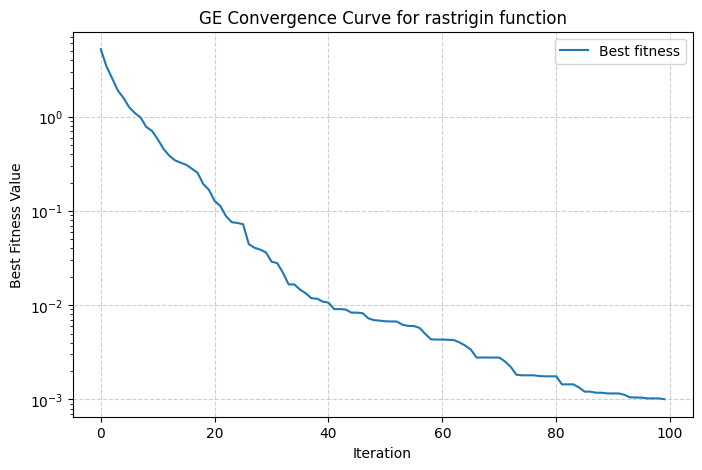

<Figure size 640x480 with 0 Axes>

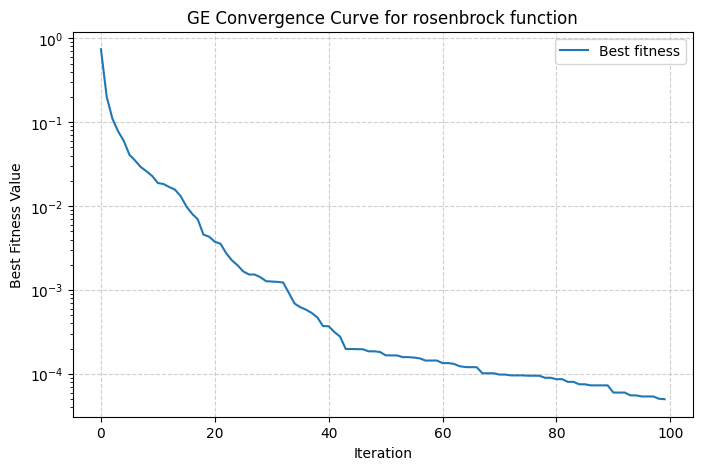

<Figure size 640x480 with 0 Axes>

In [19]:
mean_curves = {}
all_metrics = {}

for function, bounds in functions.items():
    low, high = zip(*bounds)
    all_best_fitness = []
    fitness_list_runs = []

    for run in range(num_runs):
        rng = np.random.default_rng(123 + run)
        pop, best_fitness_list = genetic_algorithm(function, pop_size, dim, low, high, gens, eta_c, pm, eta_m, rng=rng)

        fits = evaluate(pop, function)

        best_idx = np.argmin(fits)
        sol = pop[best_idx]
        fit = fits[best_idx]

        fitness_list_runs.append(best_fitness_list)
        all_best_fitness.append(fit)

    mean_for_graph = np.mean(np.array(fitness_list_runs), axis=0)
    mean_curves[function.__name__] = mean_for_graph

    # calculate metrics
    count, mean_val, median_val, std_val = metrics(np.array(all_best_fitness))
    all_metrics[function.__name__] = {
        "Count Optimal": count,
        "Mean": mean_val,
        "Median": median_val,
        "Std Dev": std_val
    } 

    # visualize results
    plt.figure(figsize=(8,5))
    plt.plot(mean_for_graph, label='Best fitness')
    plt.title(f"GE Convergence Curve for {function.__name__} function")
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness Value")
    plt.yscale("log")  
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    #plt.savefig(f"PSO_{function.__name__}_convergence.png")
    plt.show()

    plt.clf()

df_means = pd.DataFrame(mean_curves)
df_means.index.name = "Iteration"
df_means.to_csv("GA_mean_convergence_curves.csv", index=True)

df_metrics = pd.DataFrame.from_dict(all_metrics, orient="index")
df_metrics.index.name = "Function"
df_metrics.to_csv("GA_metrics.csv", index=True)


## Differential Evolution Algorithm

Using the DE/rand/1 variant

In [20]:
def differential_evolution(func, bounds, pop_size, max_gen, F, cr):
    dim = len(bounds)

    #initialize population
    pop = np.random.rand(pop_size, dim)
    for i in range(dim):
        pop[:, i] = bounds[i][0] + pop[:, i] * (bounds[i][1] - bounds[i][0])

    #evaluante initial population
    fitness = np.array([func(ind) for ind in pop])

    #best history tracking
    best_history = [np.min(fitness)]

    for gen in range(max_gen):
        for i in range(pop_size):

            # Mutation: DE/rand/1
            idxs = [idx for idx in range(pop_size) if idx != i]
            # v(i,g) = x(r0,g) + F * (x(r1,g) - x(r2,g))
            r0, r1, r2 = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(r0 + F * (r1 - r2), 
                             [b[0] for b in bounds], 
                             [b[1] for b in bounds])
            
            #crossover
            cross_points = np.random.rand(dim) < cr
            j_rand = np.random.randint(dim)
            cross_points[j_rand] = True  
            trial = np.where(cross_points, mutant, pop[i])

            #selection
            f = func(trial)
            if f < fitness[i]:
                pop[i] = trial
                fitness[i] = f

        best_history.append(np.min(fitness))
    
    # Return best solution
    best_idx = np.argmin(fitness)
    return pop[best_idx], fitness[best_idx], best_history

### Test

In [21]:
# Parameters
num_runs = 31

best_fitness = []
best_solutions = []

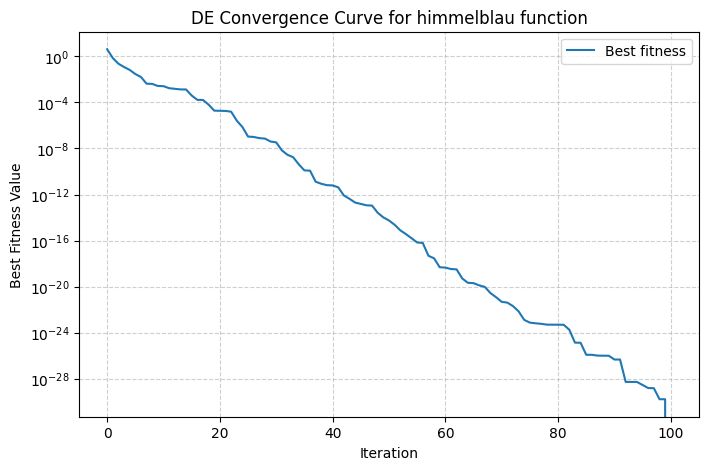

<Figure size 640x480 with 0 Axes>

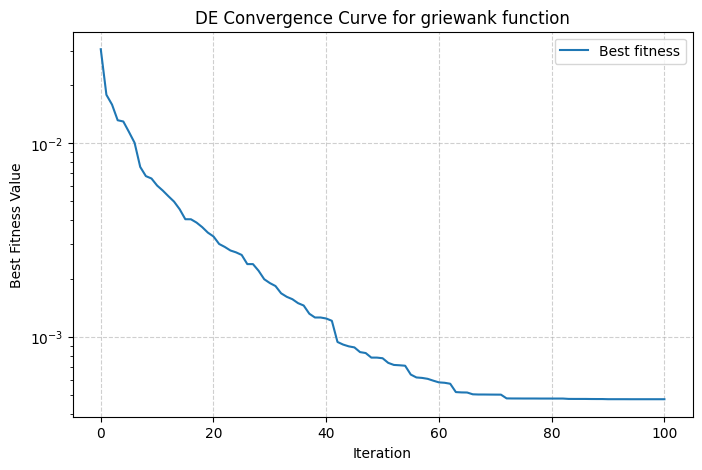

<Figure size 640x480 with 0 Axes>

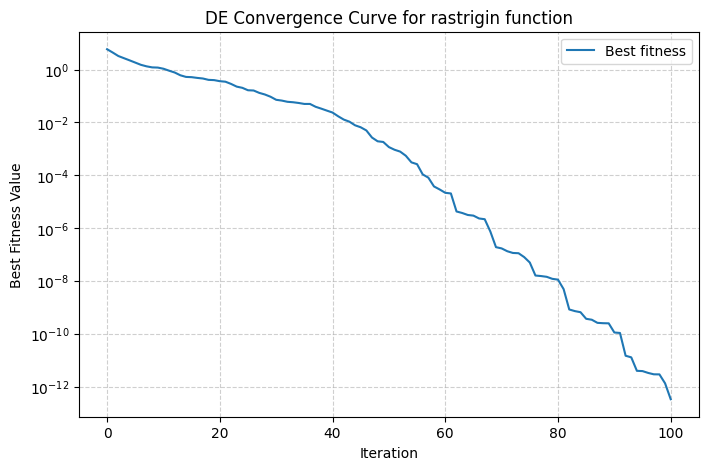

<Figure size 640x480 with 0 Axes>

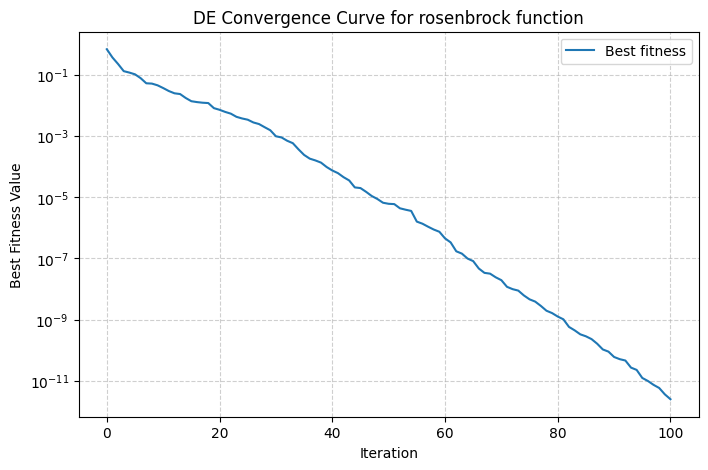

<Figure size 640x480 with 0 Axes>

In [22]:
mean_curves = {}
all_metrics = {}

for function, bounds in functions.items():

    fitness_list_runs = []
    for run in range(num_runs):

        sol, fit, fitness_list = differential_evolution(func=function, bounds=bounds, pop_size=100, max_gen=100, F=0.7, cr=0.6)
        best_fitness.append(fit)
        best_solutions.append(sol)

        fitness_list_runs.append(fitness_list)
        #print(f"Run {run+1}: Best Solution: {sol}, Best Fitness: {fit}")

    count, mean_val, median_val, std_val = metrics(np.array(best_solutions))
    all_metrics[function.__name__] = {
        "Count Optimal": count,
        "Mean": mean_val,
        "Median": median_val,
        "Std Dev": std_val
    }

    mean_for_graph = np.mean(np.array(fitness_list_runs), axis=0)
    mean_curves[function.__name__] = mean_for_graph

    # visualize results
    plt.figure(figsize=(8,5))
    plt.plot(mean_for_graph, label='Best fitness')
    plt.title(f"DE Convergence Curve for {function.__name__} function")
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness Value")
    plt.yscale("log")  
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    #plt.savefig(f"PSO_{function.__name__}_convergence.png")
    plt.show()

    plt.clf()

df_means = pd.DataFrame(mean_curves)
df_means.index.name = "Iteration"
df_means.to_csv("DE_mean_convergence_curves.csv", index=True)

df_metrics = pd.DataFrame.from_dict(all_metrics, orient="index")
df_metrics.index.name = "Function"
df_metrics.to_csv("DE_metrics.csv", index=True)

## Particle SWARM Optimization Algorithm

## Benchmark

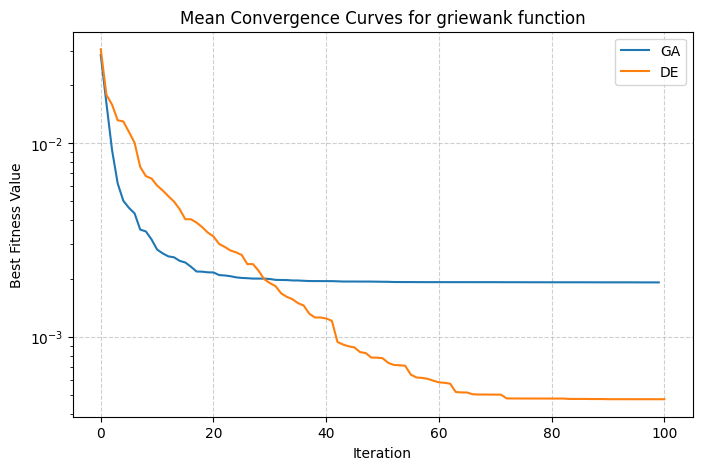

<Figure size 640x480 with 0 Axes>

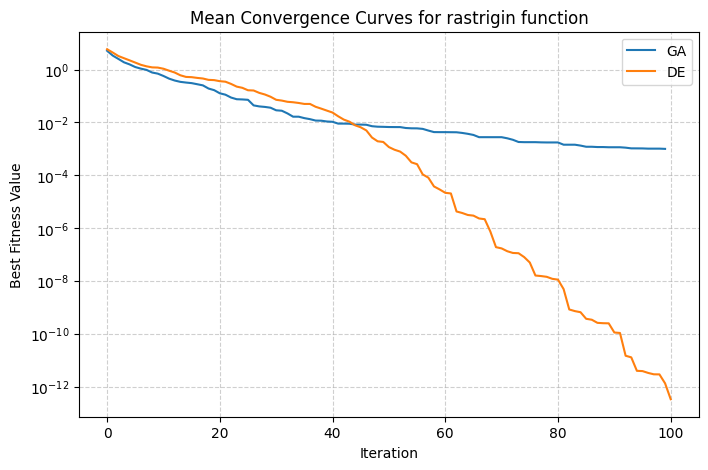

<Figure size 640x480 with 0 Axes>

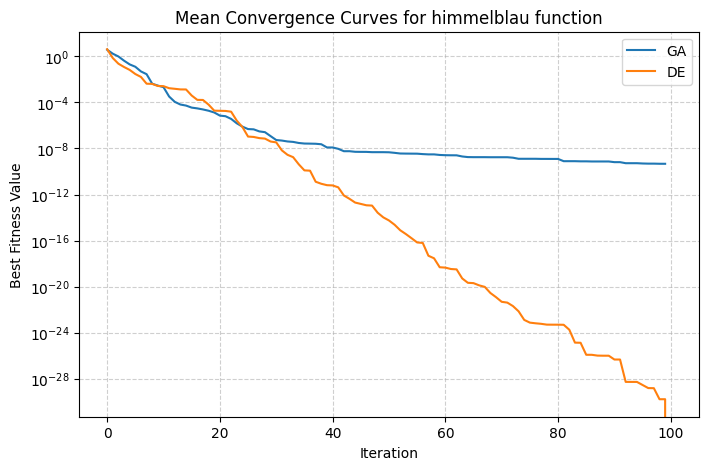

<Figure size 640x480 with 0 Axes>

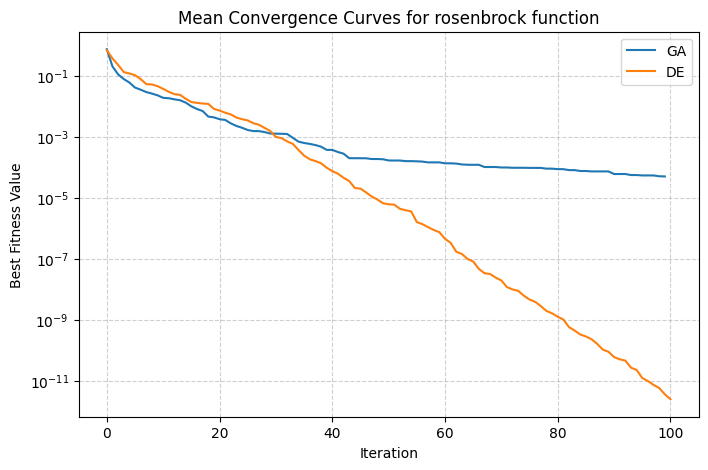

<Figure size 640x480 with 0 Axes>

In [23]:
csv_paths = {
    "GA":  "GA_mean_convergence_curves.csv",
    "DE":  "DE_mean_convergence_curves.csv",
    #"PSO": "PSO_mean_convergence_curves.csv",
}

dfs = {}
for a, path in csv_paths.items():
    df = pd.read_csv(path, index_col=0)
    df.index.name = "Iteration"
    dfs[a] = df

functions_all = set.intersection(*(set(df.columns) for df in dfs.values()))

for function in functions_all:
    plt.figure(figsize=(8,5))
    for a, df in dfs.items():
        plt.plot(df[function], label=a)
    plt.title(f"Mean Convergence Curves for {function} function")
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness Value")
    plt.yscale("log")  
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    #plt.savefig(f"Comparison_{function}_convergence.png")
    plt.show()
    plt.clf()